In [ ]:
!pip install transformers datasets scikit-learn seaborn --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os


In [ ]:
!pip install --upgrade numpy datasets

In [ ]:
# Load Dataset (Using First 5000 rows for efficiency)
df = pd.read_csv("/content/combined_data.csv").head(5000)

# Show first few rows
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5000 non-null   int64 
 1   text    5000 non-null   object
dtypes: int64(1), object(1)
memory usage: 78.3+ KB
None


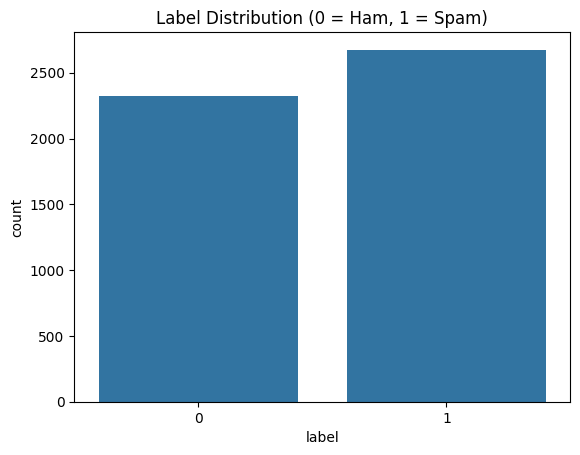

label    0
text     0
dtype: int64
Number of duplicate texts: 0


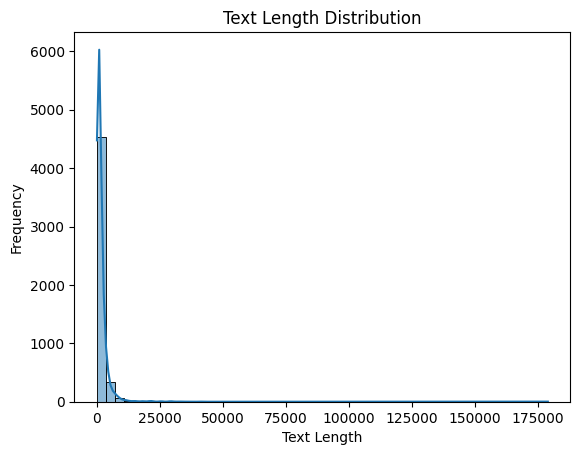

In [ ]:
# Check basic info
print(df.info())

# Check label distribution
sns.countplot(x="label", data=df)
plt.title("Label Distribution (0 = Ham, 1 = Spam)")
plt.show()

# Check null values
print(df.isnull().sum())

# Check duplicate entries
print(f"Number of duplicate texts: {df.duplicated(subset='text').sum()}")

# Distribution of text length
df["text_length"] = df["text"].apply(len)
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

# Remove text_length column (no longer needed)
df = df.drop(columns=["text_length"])

In [ ]:
# Drop nulls and duplicates
df = df.dropna(subset=["text", "label"])
df = df.drop_duplicates(subset="text")

# Ensure labels are integers
df["label"] = df["label"].astype(int)

# Reset index
df = df.reset_index(drop=True)

# Remove any auto-generated index column from datasets
if "__index_level_0__" in df.columns:
    df = df.drop(columns="__index_level_0__")

In [ ]:
# Convert to Hugging Face dataset
hf_dataset = Dataset.from_pandas(df)

# Split dataset (80% train, 20% test)
split_dataset = hf_dataset.train_test_split(test_size=0.2, seed=42)

# Check split sizes
split_dataset


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=95
    )

# Apply tokenization
tokenized_dataset = split_dataset.map(tokenize_function, batched=True)

# Set to PyTorch format
tokenized_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]